# LFSR

In [ ]:
def lfsr(seed, taps, length):
    sr = seed[:]  # copia del estado inicial
    output = []

    for _ in range(length):
        # XOR de los bits seleccionados por taps
        feedback = 0
        for t in taps:
            feedback ^= sr[t]
        
        output.append(sr[-1])  # opcional: registrar bit de salida
        sr = [feedback] + sr[:-1]  # desplazar a la derecha con feedback al frente
    
    return output

# Semilla inicial: [1, 0, 0, 1]
# Taps: [0, 3] → feedback = sr[0] ⊕ sr[3]
sequence = lfsr(seed=[1, 0, 1, 1], taps=[0, 3], length=15)
print("Secuencia LFSR generada:", sequence)

# Beacon

In [40]:
import random
import time
from collections import defaultdict
from typing import List, Tuple, Dict, Set

In [41]:
def gen_vec_strings(n: int, k: int) -> List[int]:
    if n > 64:
        raise ValueError("Only supports up to 64-bit integers.")
    return [random.getrandbits(n) for _ in range(k)]


def hamming_distance(x: int, y: int) -> int:
    return bin(x ^ y).count("1")


def create_edges(nodes: List[int], threshold: int) -> List[Tuple[int, int]]:
    edges = []
    k = len(nodes)
    for i in range(k):
        for j in range(i + 1, k):
            if hamming_distance(nodes[i], nodes[j]) <= threshold:
                edges.append((i, j))
    return edges


def gen_connectivity(k: int, edges: List[Tuple[int, int]]):
    d_count = {i: 0 for i in range(k)}
    d_connect = {i: set() for i in range(k)}
    d_degree_set = defaultdict(set)

    for i, j in edges:
        d_connect[i].add(j)
        d_connect[j].add(i)
        d_count[i] += 1
        d_count[j] += 1

    max_degree = 0
    for i in range(k):
        deg = d_count[i]
        max_degree = max(max_degree, deg)
        d_degree_set[deg].add(i)

    for d in range(max_degree):
        d_degree_set.setdefault(d, set())

    return max_degree, d_count, d_connect, d_degree_set


def filter_greedy(maxdeg: int, d_count, d_connect, d_degree_set) -> List[int]:
    import copy
    d_count = copy.deepcopy(d_count)
    d_connect = copy.deepcopy(d_connect)
    d_degree_set = copy.deepcopy(d_degree_set)

    if maxdeg < 1:
        return list(d_degree_set[0])

    for deg in range(maxdeg, 0, -1):
        while d_degree_set[deg]:
            i = d_degree_set[deg].pop()
            for j in list(d_connect[i]):
                d_connect[j].remove(i)
                old_deg = d_count[j]
                d_degree_set[old_deg].discard(j)
                d_count[j] -= 1
                d_degree_set[d_count[j]].add(j)

    assert all(len(s) == 0 for d, s in d_degree_set.items() if d > 0)
    return list(d_degree_set[0])


def filter_linear(k: int, d_connect) -> List[int]:
    available = [True] * k
    selected = []
    for i in range(k):
        if available[i]:
            selected.append(i)
            for j in d_connect[i]:
                available[j] = False
    return selected


def benchmark_hw_dist_filters(n: int, k: int, thresh: int) -> Tuple[int, int, float]:
    print(f"\nRunning benchmark with n={n}, k={k}, t={thresh}")
    t0 = time.time()

    print("Generating random strings...")
    nodes = gen_vec_strings(n, k)

    print("Creating edges...")
    edges = create_edges(nodes, thresh)

    print("Generating connectivity...")
    maxdeg, d_count, d_connect, d_degree_set = gen_connectivity(k, edges)

    print("Applying linear filter...")
    L1 = filter_linear(k, d_connect)

    print("Applying greedy filter...")
    L2 = filter_greedy(maxdeg, d_count, d_connect, d_degree_set)

    t1 = time.time()
    duration = round(t1 - t0, 4)

    print(f"Linear filter kept {len(L1)} strings ({round(len(L1) / k * 100, 2)}%)")
    print(f"Greedy filter kept {len(L2)} strings ({round(len(L2) / k * 100, 2)}%)")
    print(f"Total time: {duration} seconds")

    return len(L1), len(L2), duration


In [42]:
if __name__ == "__main__":
    n, k, t = 53, 10_000, 10
    l1, l2, duration = benchmark_hw_dist_filters(n, k, t)
    print("l1:", l1)
    print("l2:", l2)
    print("Duration:", duration)
    print("Benchmark completed.")



Running benchmark with n=53, k=10000, t=10
Generating random strings...
Creating edges...
Generating connectivity...
Applying linear filter...
Applying greedy filter...
Linear filter kept 9858 strings (98.58%)
Greedy filter kept 9858 strings (98.58%)
Total time: 16.4981 seconds
l1: 9858
l2: 9858
Duration: 16.4981
Benchmark completed.


# CTR_DRBG

In [1]:
!pip3 install cryptography

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import os
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend


class CTR_DRBG:
    def __init__(self, seed=None, key_size=32, reseed_interval=10000):
        self.key_size = key_size  # 32 bytes = AES-256
        self.backend = default_backend()
        self.reseed_interval = reseed_interval
        self.generate_counter = 0

        if seed is None:
            seed = os.urandom(self.key_size)
        #print(f"Seed: {seed.hex()}")
        self.key = seed[:self.key_size]
        self.V = int.from_bytes(os.urandom(16), 'big') # 128 bits for AES block size

    def _increment_counter(self):
        self.V = (self.V + 1) % (1 << 128)

    def _aes_encrypt(self, block_bytes):
        cipher = Cipher(algorithms.AES(self.key), modes.ECB(), backend=self.backend)
        encryptor = cipher.encryptor()
        return encryptor.update(block_bytes) + encryptor.finalize()

    def _update_state(self, additional_input=None):
        temp = b""
        v_temp = self.V
        while len(temp) < self.key_size + 16:
            input_block = v_temp.to_bytes(16, 'big')
            temp += self._aes_encrypt(input_block)
            v_temp = (v_temp + 1) % (1 << 128)

        if additional_input:
            temp = bytes(x ^ y for x, y in zip(temp, additional_input))

        self.key = temp[:self.key_size]
        self.V = int.from_bytes(temp[self.key_size:self.key_size + 16], 'big')

    def reseed(self, entropy_input=None):
        if entropy_input is None:
            entropy_input = os.urandom(self.key_size + 16)
        self._update_state(entropy_input)
        self.generate_counter = 0

    def generate(self, num_bytes, additional_input=None):
        if self.generate_counter >= self.reseed_interval:
            self.reseed()

        if additional_input:
            self._update_state(additional_input)

        output = b""
        while len(output) < num_bytes:
            input_block = self.V.to_bytes(16, 'big')
            output += self._aes_encrypt(input_block)
            self._increment_counter()

        self._update_state(additional_input)
        self.generate_counter += 1
        return output[:num_bytes]

    def get_random_bits_from_bytes(self, random_bytes):
        return ''.join(f'{byte:08b}' for byte in random_bytes)



In [36]:
drbg = CTR_DRBG(seed=bytes("5872a5d78596fc5be269b8dc4876d0c68fa7a1499f1e4fedcb2c75f8bca8d8d8", 'utf-8'))

# Generar 64 bytes aleatorios
random_bytes = drbg.generate(64)
print("Bytes aleatorios (hex):", random_bytes.hex())

bit_string = drbg.get_random_bits_from_bytes(random_bytes)
print("Bits aleatorios:", bit_string)
print("Longitud en bits:", len(bit_string))


Bytes aleatorios (hex): 1270135370459f5031713fdde7518e50766ba78e893f22235bb6009863914d4fe930ef12c07b23f84600541cf2f1613e8a072bf611894079313c76fa75ec5a10
Bits aleatorios: 00010010011100000001001101010011011100000100010110011111010100000011000101110001001111111101110111100111010100011000111001010000011101100110101110100111100011101000100100111111001000100010001101011011101101100000000010011000011000111001000101001101010011111110100100110000111011110001001011000000011110110010001111111000010001100000000001010100000111001111001011110001011000010011111010001010000001110010101111110110000100011000100101000000011110010011000100111100011101101111101001110101111011000101101000010000
Longitud en bits: 512


## Distribución en cien millones de parametros

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from collections import Counter

# Assuming CTR_DRBG is already defined and initialized
drbg = CTR_DRBG()

# Step 1: Generate 100 million bits (100,000,000 bits = 12,500,000 bytes)
random_bytes = drbg.generate(12_500_000)

# Step 2: Convert bytes to integers in range 0–255
values = list(random_bytes)

# Calcular frecuencias absolutas
byte_counts = Counter(values)

# Encontrar el más y menos frecuente
most_freq_byte = max(byte_counts, key=byte_counts.get)
least_freq_byte = min(byte_counts, key=byte_counts.get)

most_freq_density = byte_counts[most_freq_byte] / len(values)
least_freq_density = byte_counts[least_freq_byte] / len(values)


Seed: b4fd57473acda6951511a0394621da396f4fc15554b1017c1ca656c12bbbd411


KeyboardInterrupt: 

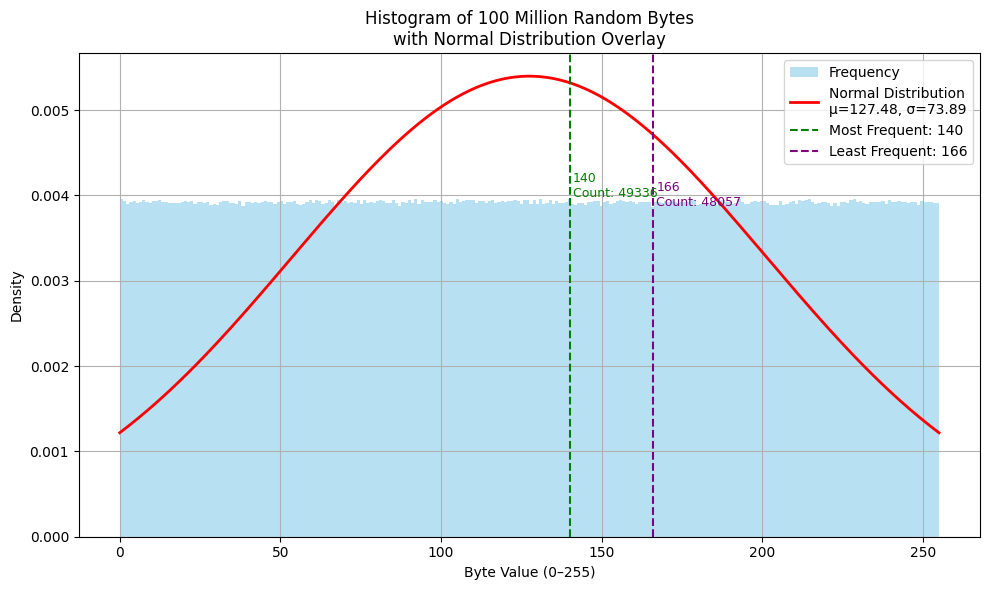

In [5]:
# Crear histograma
plt.figure(figsize=(10, 6))
count, bins, _ = plt.hist(values, bins=256, density=True, alpha=0.6, color='skyblue', label='Frequency')

# Superponer distribución normal
mu, sigma = np.mean(values), np.std(values)
x = np.linspace(0, 255, 256)
plt.plot(x, norm.pdf(x, mu, sigma), 'r-', linewidth=2, label=f'Normal Distribution\nμ={mu:.2f}, σ={sigma:.2f}')

# Resaltar el byte más frecuente
plt.axvline(most_freq_byte, color='green', linestyle='--', linewidth=1.5, label=f'Most Frequent: {most_freq_byte}')
plt.text(most_freq_byte + 1, most_freq_density, 
         f'{most_freq_byte}\nCount: {byte_counts[most_freq_byte]}',
         color='green', fontsize=9, ha='left', va='bottom')

# Resaltar el byte menos frecuente
plt.axvline(least_freq_byte, color='purple', linestyle='--', linewidth=1.5, label=f'Least Frequent: {least_freq_byte}')
plt.text(least_freq_byte + 1, least_freq_density, 
         f'{least_freq_byte}\nCount: {byte_counts[least_freq_byte]}',
         color='purple', fontsize=9, ha='left', va='bottom')

# Configurar gráfico
plt.title('Histogram of 100 Million Random Bytes\nwith Normal Distribution Overlay')
plt.xlabel('Byte Value (0–255)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Guardar como PNG
plt.savefig("random_bytes_histogram.png", dpi=300)

# Mostrar gráfico
plt.show()

## Bites más repetidos

In [6]:
from collections import Counter
import pandas as pd

byte_counts = Counter(values)

# Step 4: Get 5 most common bytes
top_5 = byte_counts.most_common(5)

# Step 5: Display as table
df_top5 = pd.DataFrame(top_5, columns=["Byte Value", "Count"])
print(df_top5.to_string(index=False))

 Byte Value  Count
        140  49336
        105  49332
        229  49258
          0  49249
        131  49247


In [7]:
from collections import Counter
import pandas as pd
import numpy as np

# Convert bytes to integers
values = list(random_bytes)

# Count each byte
byte_counts = Counter(values)

# Convert to full frequency table
freq_array = np.zeros(256, dtype=int)
for byte_val, count in byte_counts.items():
    freq_array[byte_val] = count

# Most frequent byte
most_freq_byte = np.argmax(freq_array)
most_freq_count = freq_array[most_freq_byte]

# Least frequent byte (excluding bytes that never appeared)
nonzero_freq = freq_array[freq_array > 0]
least_freq_count = np.min(nonzero_freq)
least_freq_byte = np.where(freq_array == least_freq_count)[0][0]

# Overall standard deviation of all byte frequencies
std_dev = np.std(freq_array)

# Show results in table
df_extremes = pd.DataFrame([
    {"Type": "Most Frequent", "Byte": most_freq_byte, "Count": most_freq_count},
    {"Type": "Least Frequent", "Byte": least_freq_byte, "Count": least_freq_count},
    {"Type": "Standard Deviation", "Byte": "-", "Count": f"{std_dev:.2f}"}
])
print(df_extremes.to_string(index=False))




              Type Byte  Count
     Most Frequent  140  49336
    Least Frequent  166  48057
Standard Deviation    - 223.77


In [9]:
# Cálculo de estadísticas sobre las frecuencias
mean_freq = np.mean(freq_array)
std_dev = np.std(freq_array)

# Desviaciones con respecto a la media
most_freq_dev = most_freq_count - mean_freq
least_freq_dev = least_freq_count - mean_freq

# Tabla extendida con desviaciones
df_extended = pd.DataFrame([
    {
        "Type": "Most Frequent",
        "Byte": most_freq_byte,
        "Count": most_freq_count,
        "Δ from Mean": f"{most_freq_dev:.2f}"
    },
    {
        "Type": "Least Frequent",
        "Byte": least_freq_byte,
        "Count": least_freq_count,
        "Δ from Mean": f"{least_freq_dev:.2f}"
    },
    {
        "Type": "Std. Dev. (All Counts)",
        "Byte": "-",
        "Count": f"{std_dev:.2f}",
        "Δ from Mean": "-"
    }
])

print(df_extended.to_string(index=False))


                  Type Byte  Count Δ from Mean
         Most Frequent  140  49336      507.88
        Least Frequent  166  48057     -771.12
Std. Dev. (All Counts)    - 223.77           -


# Generación números Random con la función de python

In [8]:
import random
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from scipy.stats import norm

# Paso 1: Generar una cadena de 100 millones de bits aleatorios
bit_string = bin(random.getrandbits(100_000_000))[2:]
bit_string = bit_string.zfill(100_000_000)  # Asegura que tenga exactamente 100 millones de bits

# Paso 2: Convertir cada grupo de 8 bits a un número entero (0–255)
values = [int(bit_string[i:i+8], 2) for i in range(0, len(bit_string), 8)]

In [10]:
# Paso 3: Calcular frecuencias
byte_counts = Counter(values)
most_freq_byte = max(byte_counts, key=byte_counts.get)
least_freq_byte = min(byte_counts, key=byte_counts.get)
most_freq_density = byte_counts[most_freq_byte] / len(values)
least_freq_density = byte_counts[least_freq_byte] / len(values)

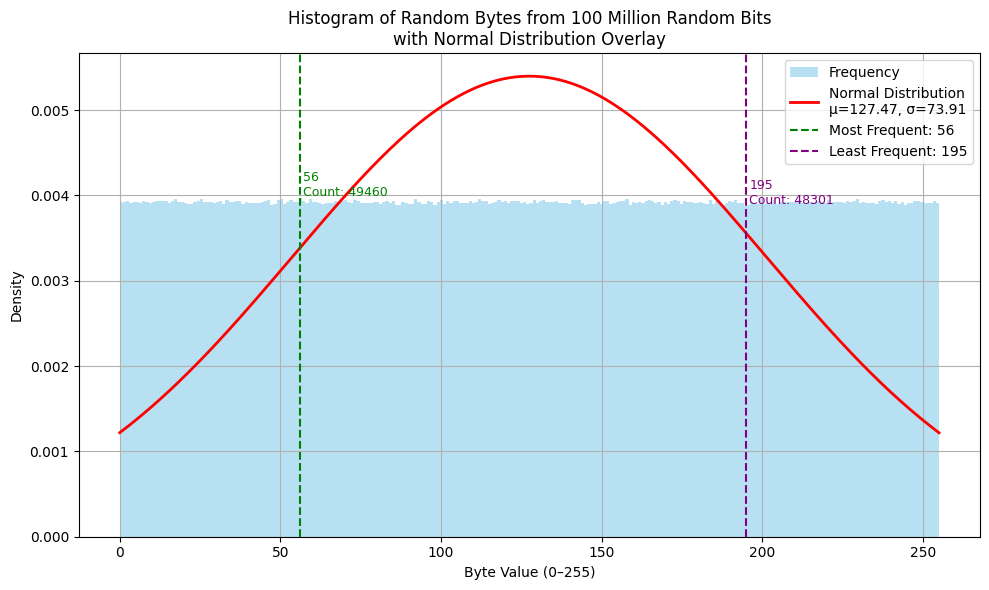

In [11]:
# Paso 4: Crear histograma
plt.figure(figsize=(10, 6))
count, bins, _ = plt.hist(values, bins=256, density=True, alpha=0.6, color='skyblue', label='Frequency')

# Paso 5: Superponer distribución normal teórica
mu, sigma = np.mean(values), np.std(values)
x = np.linspace(0, 255, 256)
plt.plot(x, norm.pdf(x, mu, sigma), 'r-', linewidth=2, label=f'Normal Distribution\nμ={mu:.2f}, σ={sigma:.2f}')

# Paso 6: Resaltar el más y el menos frecuente
plt.axvline(most_freq_byte, color='green', linestyle='--', linewidth=1.5, label=f'Most Frequent: {most_freq_byte}')
plt.text(most_freq_byte + 1, most_freq_density, 
         f'{most_freq_byte}\nCount: {byte_counts[most_freq_byte]}',
         color='green', fontsize=9, ha='left', va='bottom')

plt.axvline(least_freq_byte, color='purple', linestyle='--', linewidth=1.5, label=f'Least Frequent: {least_freq_byte}')
plt.text(least_freq_byte + 1, least_freq_density, 
         f'{least_freq_byte}\nCount: {byte_counts[least_freq_byte]}',
         color='purple', fontsize=9, ha='left', va='bottom')

# Paso 7: Configuración final
plt.title('Histogram of Random Bytes from 100 Million Random Bits\nwith Normal Distribution Overlay')
plt.xlabel('Byte Value (0–255)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Guardar imagen
plt.savefig("random_bits_histogram.png", dpi=300)

# Mostrar gráfico
plt.show()

# Generación de probabilidad de semillas secuenciales

In [17]:
def numero_a_32_bytes(n):
    if n < 0:
        raise ValueError("El número debe ser no negativo.")
    return n.to_bytes(32, byteorder='big')

In [22]:
numero = 2452452345243541234
resultado = numero_a_32_bytes(numero)
print(resultado.hex())  # para ver los bytes en formato hexadecimal


0000000000000000000000000000000000000000000000002208dc6a12d09ef2


In [28]:
# Assuming CTR_DRBG is already defined and initialized
drbg = CTR_DRBG()

# Step 1: Generate 100 million bits (100,000,000 bits = 12,500,000 bytes)
random_bytes = drbg.generate(1)
print("bits", random_bytes.hex())

Seed: b6e010a0662cca75876c7dcf2e08fc585adcc15c7bd72cff0fdc5f47f6aaefd2
bits 72


Total bytes generados: 100000000


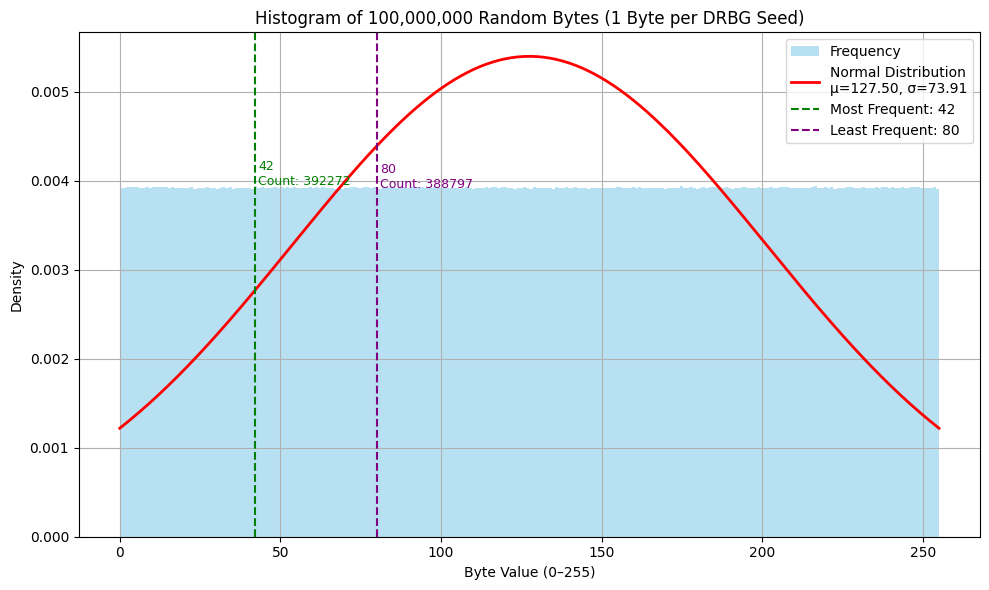

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from collections import Counter

# Asumiendo que tienes la clase CTR_DRBG correctamente definida
def numero_a_32_bytes(n):
    return n.to_bytes(32, byteorder='big')

# Generar 1 byte por cada semilla en el rango 1 a 1,000,000
random_bytes = []
for i in range(1, 100_000_001):
    drbg = CTR_DRBG(seed=numero_a_32_bytes(i))
    byte = drbg.generate(1)[0]
    random_bytes.append(byte)

print("Total bytes generados:", len(random_bytes))

# Crear histograma
values = random_bytes
byte_counts = Counter(values)

most_freq_byte = max(byte_counts, key=byte_counts.get)
least_freq_byte = min(byte_counts, key=byte_counts.get)

most_freq_density = byte_counts[most_freq_byte] / len(values)
least_freq_density = byte_counts[least_freq_byte] / len(values)

plt.figure(figsize=(10, 6))
count, bins, _ = plt.hist(values, bins=256, density=True, alpha=0.6, color='skyblue', label='Frequency')

mu, sigma = np.mean(values), np.std(values)
x = np.linspace(0, 255, 256)
plt.plot(x, norm.pdf(x, mu, sigma), 'r-', linewidth=2, label=f'Normal Distribution\nμ={mu:.2f}, σ={sigma:.2f}')

plt.axvline(most_freq_byte, color='green', linestyle='--', linewidth=1.5, label=f'Most Frequent: {most_freq_byte}')
plt.text(most_freq_byte + 1, most_freq_density, 
         f'{most_freq_byte}\nCount: {byte_counts[most_freq_byte]}',
         color='green', fontsize=9, ha='left', va='bottom')

plt.axvline(least_freq_byte, color='purple', linestyle='--', linewidth=1.5, label=f'Least Frequent: {least_freq_byte}')
plt.text(least_freq_byte + 1, least_freq_density, 
         f'{least_freq_byte}\nCount: {byte_counts[least_freq_byte]}',
         color='purple', fontsize=9, ha='left', va='bottom')

plt.title('Histogram of 100,000,000 Random Bytes (1 Byte per DRBG Seed)')
plt.xlabel('Byte Value (0–255)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Guardar y mostrar gráfico
plt.savefig("1M_drbg_histogram.png", dpi=300)
plt.show()


In [ ]:

def graficar_histograma_bytes(values, filename="random_bits_histogram.png"):
    # Paso 1: Calcular frecuencias
    byte_counts = Counter(values)
    most_freq_byte = max(byte_counts, key=byte_counts.get)
    least_freq_byte = min(byte_counts, key=byte_counts.get)
    most_freq_density = byte_counts[most_freq_byte] / len(values)
    least_freq_density = byte_counts[least_freq_byte] / len(values)

    # Paso 2: Crear histograma
    plt.figure(figsize=(10, 6))
    count, bins, _ = plt.hist(values, bins=256, density=True, alpha=0.6, color='skyblue', label='Frequency')

    # Paso 3: Superponer distribución normal
    mu, sigma = np.mean(values), np.std(values)
    x = np.linspace(0, 255, 256)
    plt.plot(x, norm.pdf(x, mu, sigma), 'r-', linewidth=2, label=f'Normal Distribution\nμ={mu:.2f}, σ={sigma:.2f}')

    # Paso 4: Resaltar el más y menos frecuente
    plt.axvline(most_freq_byte, color='green', linestyle='--', linewidth=1.5, label=f'Most Frequent: {most_freq_byte}')
    plt.text(most_freq_byte + 1, most_freq_density,
             f'{most_freq_byte}\nCount: {byte_counts[most_freq_byte]}',
             color='green', fontsize=9, ha='left', va='bottom')

    plt.axvline(least_freq_byte, color='purple', linestyle='--', linewidth=1.5, label=f'Least Frequent: {least_freq_byte}')
    plt.text(least_freq_byte + 1, least_freq_density,
             f'{least_freq_byte}\nCount: {byte_counts[least_freq_byte]}',
             color='purple', fontsize=9, ha='left', va='bottom')

    # Paso 5: Configuración final
    total_bytes = len(values)
    plt.title(f'Histogram of {total_bytes:,} Random Bytes\nwith Normal Distribution Overlay')
    plt.xlabel('Byte Value (0–255)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Paso 6: Guardar y mostrar
    plt.savefig(filename, dpi=300)
    plt.show()

def bits_a_bytes(bit_string):
    # Asegurar que la longitud sea múltiplo de 8
    if len(bit_string) % 8 != 0:
        raise ValueError("La cadena de bits debe tener una longitud múltiplo de 8.")
    
    # Convertir cada grupo de 8 bits a entero
    return [int(bit_string[i:i+8], 2) for i in range(0, len(bit_string), 8)]



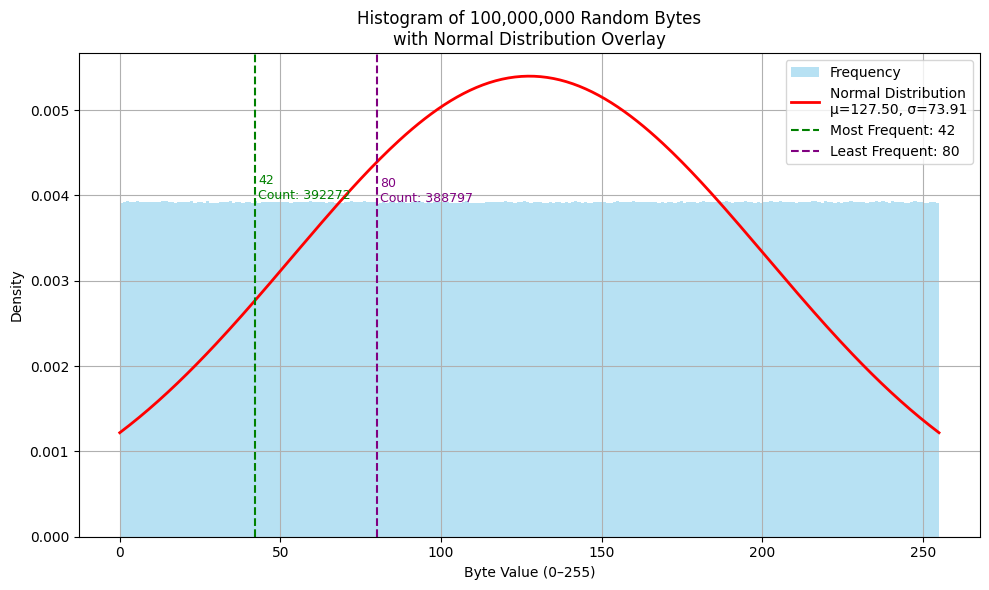

In [39]:
graficar_histograma_bytes(values, filename="1M_drbg_histogram.png")

In [45]:
import requests

def obtener_outputvalue_bytes(pulse_url):
    # Consultar la API
    response = requests.get(pulse_url)
    response.raise_for_status()
    
    data = response.json()
    hex_string = data['pulse']['outputValue']
    
    # Convertir de hexadecimal a bytes
    byte_data = bytes.fromhex(hex_string)
    
    # Convertir bytes a lista de enteros
    byte_list = list(byte_data)
    
    return byte_list

In [46]:
# URL del pulso específico
url = "https://beacon.nist.gov/beacon/2.0/chain/2/pulse/1338590"

# Obtener y mostrar lista de bytes
bytes_lista = obtener_outputvalue_bytes(url)
print(bytes_lista)
print(len(bytes_lista))  # Longitud de la lista

[92, 208, 52, 2, 124, 161, 188, 65, 106, 238, 167, 27, 224, 75, 6, 110, 188, 70, 165, 188, 32, 3, 57, 144, 129, 76, 77, 54, 231, 172, 221, 127, 199, 107, 99, 154, 84, 31, 40, 244, 12, 51, 114, 181, 58, 34, 173, 163, 135, 3, 27, 108, 237, 163, 229, 96, 226, 225, 144, 59, 227, 181, 137, 145]
64


In [ ]:
random_bytes = []
index_pulse = 1338590
for i in range(0, 15625):
    new_index = index_pulse - i
    request_url = f"https://beacon.nist.gov/beacon/2.0/chain/2/pulse/{new_index}"
    bytes_lista = obtener_outputvalue_bytes(request_url)
    random_bytes.append(bytes_lista)




In [ ]:
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.notebook import tqdm

def obtener_outputvalue_bytes(pulse_url):
    try:
        response = requests.get(pulse_url, timeout=10)
        response.raise_for_status()
        data = response.json()
        hex_string = data['pulse']['outputValue']
        byte_data = bytes.fromhex(hex_string)
        return list(byte_data)
    except Exception as e:
        print(f"Error en {pulse_url}: {e}")
        return None

def descargar_valores_en_paralelo(index_pulse, cantidad=15625, max_workers=20):
    random_bytes = []
    urls = [
        f"https://beacon.nist.gov/beacon/2.0/chain/2/pulse/{index_pulse - i}"
        for i in range(cantidad)
    ]

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(obtener_outputvalue_bytes, url): url for url in urls}
        for future in tqdm(as_completed(futures), total=len(futures), desc="Descargando en paralelo"):
            result = future.result()
            if result is not None:
                random_bytes.append(result)

    return random_bytes

# Uso
index_pulse = 1338590
random_bytes = descargar_valores_en_paralelo(index_pulse)

Descargando en paralelo:   0%|          | 0/15625 [00:00<?, ?it/s]